In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import cv2
from gait import *
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from utils import angle_ims, get_device

In [19]:
y = np.mean([image for image in images_0_4],axis=0)
mean_frame = np.mean([image for image in images_0_4],axis=0)

In [5]:
class Conv3D(nn.Module):

    '''
    Performs 3D convolution
    '''

    def __init__(self):

        super(Conv3D, self).__init__()
        self.conv1 = self._convblock(1,16,3,1,False)
        self.conv2 = self._convblock(16,32,1,1,False)
        self.conv3 = self._convblock(32,16,1,1,False)
        self.conv4 = self._convblock(16,1,1,1,True)

    def _convblock(self,in_channels,out_channels,ksized,ksize,last):
        '''
        Makes a block of layers (Conv3d,ReLU,Maxpool3d,BatchNorm3d(only if !last))
        '''

        l1 = nn.Conv3d(in_channels=in_channels,out_channels=out_channels,kernel_size=(ksized,ksize,ksize))
        l2 = nn.ReLU()
        
        if last:
            return nn.Sequential(l1,l2)
        else:
            l3 = nn.MaxPool3d((1, 1, 1))
            l4 = nn.BatchNorm3d(out_channels)
            return nn.Sequential(l1,l2,l3,l4)
        
        
    def forward(self,x):

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        
        return out


In [6]:
model = Conv3D()

In [7]:
model = Conv3D()
device = get_device()
print(device)
model.to(device)

cuda:0


Conv3D(
  (conv1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv3d(32, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv3d(16, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): ReLU()

In [8]:
class PEIData(Dataset):

    def __init__(self, num_exps,transform=None):
        """
        Custom dataset for images of a certain keypose at a given angle.

        Args:
            angle (int)     : Angle
            keypose (int)   : Key-pose/Cluster
            data_path (str) : Path where dataset is downloaded
        """
        
        ds = []
        for i in range(num_exps):
            exp = angle_ims(exp=i+1,angle=0,keypose = 4)
            ds = ds + exp

        images = np.empty((len(ds),3,ds[0].shape[2]//2,ds[0].shape[1]//2))

        for i in range(len(ds)):
            images[i] = np.asarray([preprocess(im)/255 for im in ds[i]])
        
        self.images = images.reshape(images.shape[0],1,images.shape[1],images.shape[2],images.shape[3]).astype('float32')

        #Avg PEI after PCA .
        # self.y = np.mean([image for image in images_0_4],axis=0)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

In [11]:
data = PEIData(6)

In [12]:
len(data)

33

In [ ]:
data[0].shape

## Training

In [20]:
dl = DataLoader(data, 8, False)
#Loss
criterion = nn.MSELoss()
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
y = torch.from_numpy(y).to(device,dtype=torch.float)

In [13]:
data[0].dtype

dtype('float32')

In [31]:
n_epochs = 15

for epoch in range(1, n_epochs+1):
    # monitor training loss
    total_loss = 0.0

    #Training
    for data in dl:
        images = data
        images = images.to(device)
        optimizer.zero_grad()
        out = model(images)
        batch = out.shape[0]
        # print(out.shape[0])
        temp = torch.tile(y,(batch,1,1))

        temp_out = torch.reshape(out, (out.shape[0],out.shape[3],out.shape[4]))
        # print('Outputs: ',temp_out.shape,' Targets shape: ',y.shape)
        loss = criterion(temp_out, temp)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()*images.size(0)

        del temp
          
    train_loss = train_loss/len(dl)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [30]:
torch.cuda.empty_cache()

## CHECK

In [45]:
def ims(img):
    plt.imshow(np.transpose(img, (1, 2, 0)),cmap='gray',vmax=1) 

### Only for 2 exps (i.e, 14*3 = 42 images)

<class 'torch.Tensor'> torch.Size([2, 1, 3, 160, 120])
output:  torch.Size([2, 1, 1, 160, 120])
output:  torch.Size([2, 1, 160, 120])
Reconstructed Images


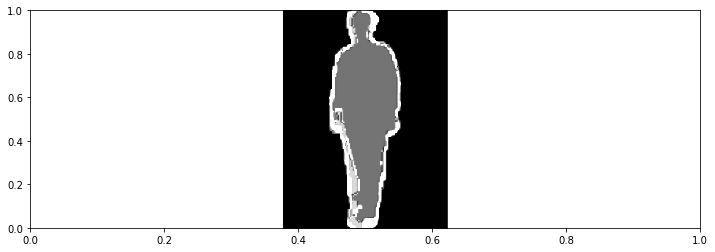

In [50]:
dataiter = iter(dl)
images = dataiter.next()
# images = images.to('cpu',dtype=torch.float)
print(type(images),images.shape)

model = model

#Sample outputs
output = model(images.to(device=device))
print('output: ',output.shape)
images = images.numpy()
output = output.view(batch, 1, 160, 120)
print('output: ',output.shape)
output = output.cpu().detach().numpy()
out = np.mean([image for image in output],axis=0)

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(1):
    ax = fig.add_subplot(1, 1, idx+1, xticks=[], yticks=[])
    ims(out)
plt.show() 

## USE FOR Y

In [ ]:
out.max()

In [53]:
# cv2.imshow('',mean_frame)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

## Encoder testings
input:  `<class 'torch.Tensor'> torch.Size([m, 1, 160, 120])`

In [16]:
from encoder import Autoencoder